# Setup

In [193]:
# import os
# import datetime

# import IPython
# import IPython.display
# import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# import tensorflow as tf

# mpl.rcParams['figure.figsize'] = (8, 6)
# mpl.rcParams['axes.grid'] = False

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Dataset

In [194]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DL_Project/train.csv', sep = ',')

In [195]:
df.head(10)

,x,y,z
0,-24,749,-626
1,-206,930,-63
2,-139,763,-577
3,-503,441,-557
4,-278,705,-396
5,240,839,-310
6,-671,318,-213
7,-45,296,-927
8,102,294,-888
9,15,635,-671


In [196]:
df.tail(10)

,x,y,z
144901,558,-803,-294
144902,558,-803,-294
144903,558,-802,-294
144904,559,-803,-294
144905,559,-803,-294
144906,559,-803,-294
144907,559,-803,-294
144908,559,-802,-295
144909,559,-803,-294
144910,559,-802,-294


In [197]:
df.shape

(144911, 3)

In [198]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144911 entries, 0 to 144910
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   x       144911 non-null  int64
 1   y       144911 non-null  int64
 2   z       144911 non-null  int64
dtypes: int64(3)
memory usage: 3.3 MB


In [199]:
t = range(0, len(df['x']) * 10, 10)
x = df['x']
y = df['y']
z = df['z']

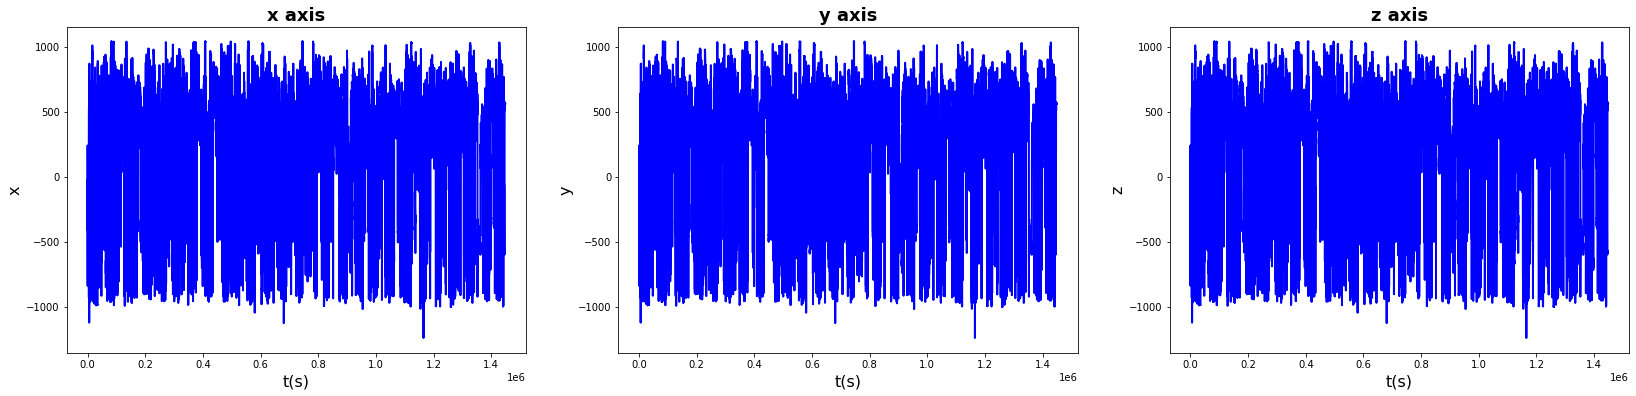

In [200]:
fig, axs = plt.subplots(1, 3,figsize=(28, 6))

axes = ['x', 'y', 'z']

for i in range(3):
  axs[i].plot(t, x, color='b', linewidth=2, label='x')
  axs[i].set_title(f"{axes[i]} axis", size=18, fontweight="bold")
  axs[i].set_xlabel('t(s)', size=16)
  axs[i].set_ylabel(axes[i], size=16)


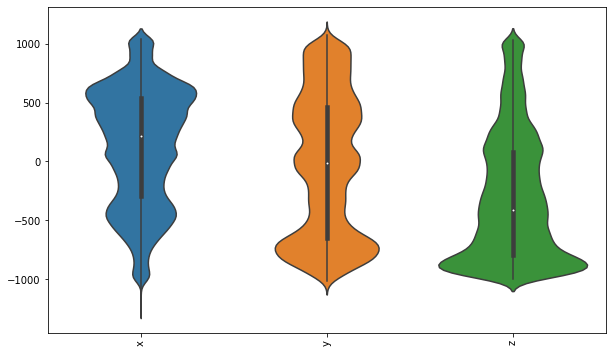

In [201]:
plt.figure(figsize=(10, 6))
ax = sns.violinplot(data=df)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Inspect and cleanup

In [202]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
x,144911.0,132.732967,491.697810,-1239.0,-291.0,214.0,539.0,1039.0
y,144911.0,-34.800146,594.977813,-1019.0,-646.0,-14.0,466.0,1078.0
z,144911.0,-307.588768,538.335654,-1001.0,-794.0,-416.0,83.0,1032.0


## Feature engineering

## Split the data

In [203]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.8)]
val_df   = df[int(n*0.8):]

num_features = df.shape[1]

In [204]:
train_df.shape

(115928, 3)

In [205]:
val_df.shape

(28983, 3)

## Normalize the data

In [206]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std

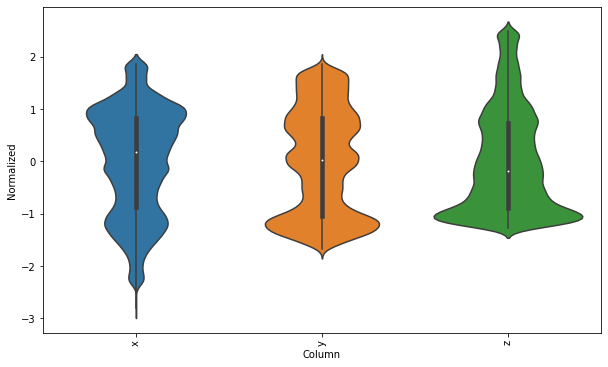

In [207]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')

plt.figure(figsize=(10, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

# Data windowing

In [208]:
def split(data, win_size=30, win_shift=5, offset=1):
  
  rows = np.arange(win_size, len(train_df) - win_shift- 1, win_shift)
  
  samples = np.zeros((len(rows), win_size, df.shape[-1]))
  
  targets = np.zeros((len(rows),))
  
  for j, row in enumerate(rows):
    samples[j] = train_df[j * win_shift: row]
    targets[j] = train_df[row: row + offset]['x']
   
  return samples, targets

# Window 5 min Shift 1 min

In [209]:
x_train, y_train = split(train_df)
x_val  , y_val  = split(val_df)

In [210]:
seq_len = x_train.shape[1]
num_feat = x_train.shape[2]

## Model 1

In [211]:
model = Sequential()

model.add(layers.LSTM(16, input_shape = (seq_len, num_feat), return_sequences = True))
model.add(layers.Dense(1))

model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 30, 16)            1280      
                                                                 
 dense_59 (Dense)            (None, 30, 1)             17        
                                                                 
Total params: 1,297
Trainable params: 1,297
Non-trainable params: 0
_________________________________________________________________


In [212]:
model.compile(loss = 'mae', optimizer='adam')

In [213]:
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), verbose = 1, batch_size=32, shuffle=False)

Epoch 1/10
725/725 [==============================] - 18s 22ms/step - loss: 0.6089 - val_loss: 0.5566
Epoch 2/10
725/725 [==============================] - 17s 23ms/step - loss: 0.5551 - val_loss: 0.5492
Epoch 3/10
725/725 [==============================] - 13s 18ms/step - loss: 0.5495 - val_loss: 0.5452
Epoch 4/10
725/725 [==============================] - 14s 19ms/step - loss: 0.5463 - val_loss: 0.5426
Epoch 5/10
725/725 [==============================] - 14s 19ms/step - loss: 0.5432 - val_loss: 0.5392
Epoch 6/10
725/725 [==============================] - 14s 19ms/step - loss: 0.5408 - val_loss: 0.5367
Epoch 7/10
725/725 [==============================] - 14s 19ms/step - loss: 0.5384 - val_loss: 0.5351
Epoch 8/10
725/725 [==============================] - 13s 18ms/step - loss: 0.5368 - val_loss: 0.5337
Epoch 9/10
725/725 [==============================] - 13s 18ms/step - loss: 0.5350 - val_loss: 0.5336
Epoch 10/10
725/725 [==============================] - 14s 19ms/step - loss: 0.533

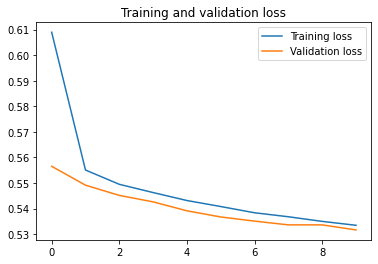

In [214]:
loss = history.history['loss'] 
val_loss = history.history['val_loss']
epochs = range(len(loss)) 

plt.plot(epochs, loss,  label='Training loss') 
plt.plot(epochs, val_loss,  label='Validation loss') 
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Model 2

In [215]:
model = Sequential()

model.add(layers.LSTM(32, input_shape = (seq_len, num_feat), return_sequences = True))
model.add(layers.Dense(1))

model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 30, 32)            4608      
                                                                 
 dense_60 (Dense)            (None, 30, 1)             33        
                                                                 
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


In [216]:
model.compile(loss = 'mae', optimizer='adam')

In [217]:
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), verbose = 1, batch_size=64, shuffle=False)

Epoch 1/10
363/363 [==============================] - 11s 25ms/step - loss: 0.7039 - val_loss: 0.6683
Epoch 2/10
363/363 [==============================] - 8s 23ms/step - loss: 0.6697 - val_loss: 0.6635
Epoch 3/10
363/363 [==============================] - 8s 23ms/step - loss: 0.6660 - val_loss: 0.6618
Epoch 4/10
363/363 [==============================] - 8s 22ms/step - loss: 0.6635 - val_loss: 0.6605
Epoch 5/10
363/363 [==============================] - 8s 22ms/step - loss: 0.6619 - val_loss: 0.6593
Epoch 6/10
363/363 [==============================] - 9s 24ms/step - loss: 0.6607 - val_loss: 0.6579
Epoch 7/10
363/363 [==============================] - 8s 22ms/step - loss: 0.6596 - val_loss: 0.6570
Epoch 8/10
363/363 [==============================] - 8s 22ms/step - loss: 0.6591 - val_loss: 0.6564
Epoch 9/10
363/363 [==============================] - 9s 24ms/step - loss: 0.6581 - val_loss: 0.6562
Epoch 10/10
363/363 [==============================] - 8s 23ms/step - loss: 0.6576 - val_l

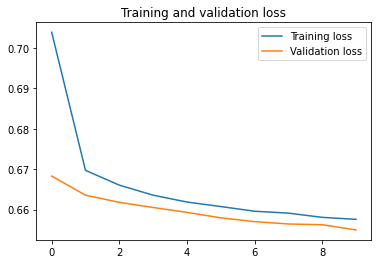

In [218]:
loss = history.history['loss'] 
val_loss = history.history['val_loss']
epochs = range(len(loss)) 

plt.plot(epochs, loss,  label='Training loss') 
plt.plot(epochs, val_loss,  label='Validation loss') 
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Model 3 Dropout

In [219]:
model = Sequential()

model.add(layers.LSTM(32, dropout=0.2, input_shape = (seq_len, num_feat), return_sequences = True))
model.add(layers.Dense(1))

model.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_35 (LSTM)              (None, 30, 32)            4608      
                                                                 
 dense_61 (Dense)            (None, 30, 1)             33        
                                                                 
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


In [220]:
model.compile(loss = 'mae', optimizer='adam')

In [221]:
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), verbose = 1, batch_size=64, shuffle=False)

Epoch 1/10
363/363 [==============================] - 11s 23ms/step - loss: 0.7034 - val_loss: 0.6707
Epoch 2/10
363/363 [==============================] - 8s 23ms/step - loss: 0.6774 - val_loss: 0.6665
Epoch 3/10
363/363 [==============================] - 8s 23ms/step - loss: 0.6745 - val_loss: 0.6643
Epoch 4/10
363/363 [==============================] - 8s 23ms/step - loss: 0.6726 - val_loss: 0.6633
Epoch 5/10
363/363 [==============================] - 8s 21ms/step - loss: 0.6716 - val_loss: 0.6624
Epoch 6/10
363/363 [==============================] - 8s 23ms/step - loss: 0.6704 - val_loss: 0.6617
Epoch 7/10
363/363 [==============================] - 8s 23ms/step - loss: 0.6698 - val_loss: 0.6612
Epoch 8/10
363/363 [==============================] - 9s 24ms/step - loss: 0.6688 - val_loss: 0.6608
Epoch 9/10
363/363 [==============================] - 9s 24ms/step - loss: 0.6677 - val_loss: 0.6604
Epoch 10/10
363/363 [==============================] - 8s 23ms/step - loss: 0.6671 - val_l

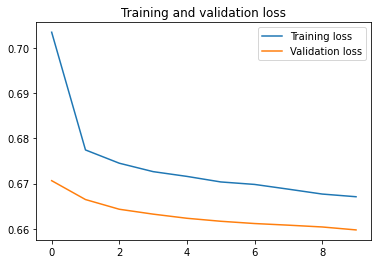

In [222]:
loss = history.history['loss'] 
val_loss = history.history['val_loss']
epochs = range(len(loss)) 

plt.plot(epochs, loss,  label='Training loss') 
plt.plot(epochs, val_loss,  label='Validation loss') 
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Model 4 Recurrent Dropout

In [223]:
model = Sequential()

model.add(layers.LSTM(32, recurrent_dropout=0.2, input_shape = (seq_len, num_feat), return_sequences = True))
model.add(layers.Dense(1))

model.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 30, 32)            4608      
                                                                 
 dense_62 (Dense)            (None, 30, 1)             33        
                                                                 
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


In [224]:
model.compile(loss = 'mae', optimizer='adam')

In [225]:
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), verbose = 1, batch_size=64, shuffle=False)

Epoch 1/10
363/363 [==============================] - 16s 37ms/step - loss: 0.6958 - val_loss: 0.6673
Epoch 2/10
363/363 [==============================] - 13s 37ms/step - loss: 0.6700 - val_loss: 0.6628
Epoch 3/10
363/363 [==============================] - 14s 38ms/step - loss: 0.6664 - val_loss: 0.6603
Epoch 4/10
363/363 [==============================] - 13s 37ms/step - loss: 0.6641 - val_loss: 0.6587
Epoch 5/10
363/363 [==============================] - 13s 37ms/step - loss: 0.6626 - val_loss: 0.6573
Epoch 6/10
363/363 [==============================] - 13s 37ms/step - loss: 0.6616 - val_loss: 0.6563
Epoch 7/10
363/363 [==============================] - 13s 37ms/step - loss: 0.6606 - val_loss: 0.6555
Epoch 8/10
363/363 [==============================] - 13s 36ms/step - loss: 0.6597 - val_loss: 0.6550
Epoch 9/10
363/363 [==============================] - 13s 35ms/step - loss: 0.6589 - val_loss: 0.6542
Epoch 10/10
363/363 [==============================] - 13s 35ms/step - loss: 0.658

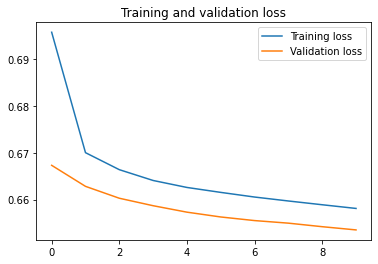

In [226]:
loss = history.history['loss'] 
val_loss = history.history['val_loss']
epochs = range(len(loss)) 

plt.plot(epochs, loss,  label='Training loss') 
plt.plot(epochs, val_loss,  label='Validation loss') 
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Model 5

In [228]:
model = Sequential()

model.add(layers.LSTM(32, recurrent_dropout=0.2, input_shape = (seq_len, num_feat), return_sequences = True))
model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1))

model.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_38 (LSTM)              (None, 30, 32)            4608      
                                                                 
 dense_65 (Dense)            (None, 30, 16)            528       
                                                                 
 dropout_29 (Dropout)        (None, 30, 16)            0         
                                                                 
 dense_66 (Dense)            (None, 30, 1)             17        
                                                                 
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


In [229]:
model.compile(loss = 'mae', optimizer='adam')

In [230]:
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), verbose = 1, batch_size=128, shuffle=False)

Epoch 1/10
182/182 [==============================] - 16s 69ms/step - loss: 0.7940 - val_loss: 0.7590
Epoch 2/10
182/182 [==============================] - 18s 100ms/step - loss: 0.7667 - val_loss: 0.7547
Epoch 3/10
182/182 [==============================] - 20s 110ms/step - loss: 0.7630 - val_loss: 0.7526
Epoch 4/10
182/182 [==============================] - 13s 73ms/step - loss: 0.7615 - val_loss: 0.7515
Epoch 5/10
182/182 [==============================] - 9s 51ms/step - loss: 0.7602 - val_loss: 0.7508
Epoch 6/10
182/182 [==============================] - 9s 47ms/step - loss: 0.7592 - val_loss: 0.7502
Epoch 7/10
182/182 [==============================] - 9s 49ms/step - loss: 0.7585 - val_loss: 0.7498
Epoch 8/10
182/182 [==============================] - 10s 54ms/step - loss: 0.7579 - val_loss: 0.7494
Epoch 9/10
182/182 [==============================] - 9s 47ms/step - loss: 0.7574 - val_loss: 0.7491
Epoch 10/10
182/182 [==============================] - 9s 50ms/step - loss: 0.7571 -

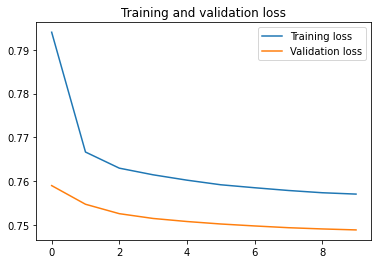

In [231]:
loss = history.history['loss'] 
val_loss = history.history['val_loss']
epochs = range(len(loss)) 

plt.plot(epochs, loss,  label='Training loss') 
plt.plot(epochs, val_loss,  label='Validation loss') 
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Model 6

In [232]:
model = Sequential()

model.add(layers.LSTM(32, recurrent_dropout=0.2, input_shape = (seq_len, num_feat), return_sequences = True))
model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1))

model.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, 30, 32)            4608      
                                                                 
 dense_67 (Dense)            (None, 30, 16)            528       
                                                                 
 dropout_30 (Dropout)        (None, 30, 16)            0         
                                                                 
 dense_68 (Dense)            (None, 30, 1)             17        
                                                                 
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


In [233]:
model.compile(loss = 'mae', optimizer='adam')

In [234]:
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), verbose = 1, batch_size=64, shuffle=False)

Epoch 1/10
363/363 [==============================] - 17s 38ms/step - loss: 0.7109 - val_loss: 0.6705
Epoch 2/10
363/363 [==============================] - 14s 38ms/step - loss: 0.6829 - val_loss: 0.6669
Epoch 3/10
363/363 [==============================] - 15s 40ms/step - loss: 0.6792 - val_loss: 0.6647
Epoch 4/10
363/363 [==============================] - 14s 39ms/step - loss: 0.6766 - val_loss: 0.6632
Epoch 5/10
363/363 [==============================] - 13s 37ms/step - loss: 0.6747 - val_loss: 0.6618
Epoch 6/10
363/363 [==============================] - 14s 39ms/step - loss: 0.6735 - val_loss: 0.6602
Epoch 7/10
363/363 [==============================] - 16s 43ms/step - loss: 0.6721 - val_loss: 0.6588
Epoch 8/10
363/363 [==============================] - 14s 39ms/step - loss: 0.6709 - val_loss: 0.6576
Epoch 9/10
363/363 [==============================] - 14s 38ms/step - loss: 0.6699 - val_loss: 0.6570
Epoch 10/10
363/363 [==============================] - 14s 40ms/step - loss: 0.668

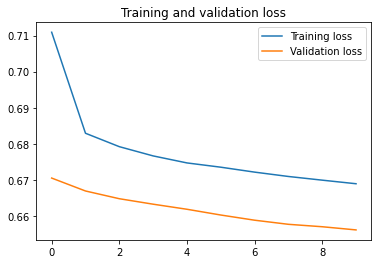

In [235]:
loss = history.history['loss'] 
val_loss = history.history['val_loss']
epochs = range(len(loss)) 

plt.plot(epochs, loss,  label='Training loss') 
plt.plot(epochs, val_loss,  label='Validation loss') 
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Model 7

In [236]:
model = Sequential()

model.add(layers.LSTM(32, recurrent_dropout=0.3, input_shape = (seq_len, num_feat), return_sequences = True))
model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1))

model.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 30, 32)            4608      
                                                                 
 dense_69 (Dense)            (None, 30, 16)            528       
                                                                 
 dropout_31 (Dropout)        (None, 30, 16)            0         
                                                                 
 dense_70 (Dense)            (None, 30, 1)             17        
                                                                 
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


In [237]:
model.compile(loss = 'mae', optimizer='adam')

In [238]:
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), verbose = 1, batch_size=64, shuffle=False)

Epoch 1/10
363/363 [==============================] - 17s 38ms/step - loss: 0.7193 - val_loss: 0.6711
Epoch 2/10
363/363 [==============================] - 14s 39ms/step - loss: 0.6866 - val_loss: 0.6678
Epoch 3/10
363/363 [==============================] - 15s 40ms/step - loss: 0.6831 - val_loss: 0.6659
Epoch 4/10
363/363 [==============================] - 14s 38ms/step - loss: 0.6810 - val_loss: 0.6648
Epoch 5/10
363/363 [==============================] - 14s 37ms/step - loss: 0.6798 - val_loss: 0.6639
Epoch 6/10
363/363 [==============================] - 15s 41ms/step - loss: 0.6788 - val_loss: 0.6632
Epoch 7/10
363/363 [==============================] - 14s 39ms/step - loss: 0.6780 - val_loss: 0.6628
Epoch 8/10
363/363 [==============================] - 14s 37ms/step - loss: 0.6774 - val_loss: 0.6624
Epoch 9/10
363/363 [==============================] - 14s 40ms/step - loss: 0.6766 - val_loss: 0.6617
Epoch 10/10
363/363 [==============================] - 15s 40ms/step - loss: 0.676

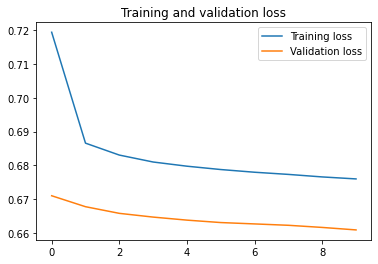

In [239]:
loss = history.history['loss'] 
val_loss = history.history['val_loss']
epochs = range(len(loss)) 

plt.plot(epochs, loss,  label='Training loss') 
plt.plot(epochs, val_loss,  label='Validation loss') 
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Model 8

In [240]:
model = Sequential()

model.add(layers.LSTM(32, recurrent_dropout=0.3, input_shape = (seq_len, num_feat), return_sequences = True))
model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1))

model.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_41 (LSTM)              (None, 30, 32)            4608      
                                                                 
 dense_71 (Dense)            (None, 30, 16)            528       
                                                                 
 dropout_32 (Dropout)        (None, 30, 16)            0         
                                                                 
 dense_72 (Dense)            (None, 30, 1)             17        
                                                                 
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


In [241]:
model.compile(loss = 'mae', optimizer='adam')

In [242]:
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), verbose = 1, batch_size=128, shuffle=False)

Epoch 1/10
182/182 [==============================] - 12s 52ms/step - loss: 0.7877 - val_loss: 0.7585
Epoch 2/10
182/182 [==============================] - 9s 50ms/step - loss: 0.7722 - val_loss: 0.7559
Epoch 3/10
182/182 [==============================] - 9s 49ms/step - loss: 0.7691 - val_loss: 0.7544
Epoch 4/10
182/182 [==============================] - 9s 49ms/step - loss: 0.7674 - val_loss: 0.7535
Epoch 5/10
182/182 [==============================] - 9s 49ms/step - loss: 0.7662 - val_loss: 0.7528
Epoch 6/10
182/182 [==============================] - 9s 50ms/step - loss: 0.7654 - val_loss: 0.7523
Epoch 7/10
182/182 [==============================] - 9s 51ms/step - loss: 0.7647 - val_loss: 0.7520
Epoch 8/10
182/182 [==============================] - 9s 48ms/step - loss: 0.7642 - val_loss: 0.7516
Epoch 9/10
182/182 [==============================] - 9s 48ms/step - loss: 0.7640 - val_loss: 0.7515
Epoch 10/10
182/182 [==============================] - 9s 51ms/step - loss: 0.7635 - val_l

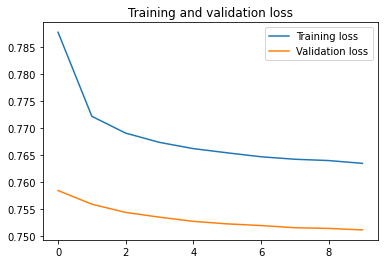

In [243]:
loss = history.history['loss'] 
val_loss = history.history['val_loss']
epochs = range(len(loss)) 

plt.plot(epochs, loss,  label='Training loss') 
plt.plot(epochs, val_loss,  label='Validation loss') 
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Model 9

In [252]:
model = Sequential()

model.add(layers.LSTM(32, recurrent_dropout=0.3, input_shape = (seq_len, num_feat), return_sequences = True))
model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(8, activation = 'relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1))

model.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 30, 32)            4608      
                                                                 
 dense_80 (Dense)            (None, 30, 16)            528       
                                                                 
 dropout_38 (Dropout)        (None, 30, 16)            0         
                                                                 
 dense_81 (Dense)            (None, 30, 8)             136       
                                                                 
 dropout_39 (Dropout)        (None, 30, 8)             0         
                                                                 
 dense_82 (Dense)            (None, 30, 1)             9         
                                                                 
Total params: 5,281
Trainable params: 5,281
Non-train

In [253]:
model.compile(loss = 'mae', optimizer='adam')

In [246]:
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), verbose = 1, batch_size=128, shuffle=False)

Epoch 1/10
182/182 [==============================] - 14s 57ms/step - loss: 0.8028 - val_loss: 0.7704
Epoch 2/10
182/182 [==============================] - 9s 47ms/step - loss: 0.7844 - val_loss: 0.7658
Epoch 3/10
182/182 [==============================] - 9s 50ms/step - loss: 0.7800 - val_loss: 0.7634
Epoch 4/10
182/182 [==============================] - 9s 50ms/step - loss: 0.7776 - val_loss: 0.7613
Epoch 5/10
182/182 [==============================] - 9s 50ms/step - loss: 0.7758 - val_loss: 0.7597
Epoch 6/10
182/182 [==============================] - 10s 52ms/step - loss: 0.7744 - val_loss: 0.7588
Epoch 7/10
182/182 [==============================] - 9s 49ms/step - loss: 0.7734 - val_loss: 0.7578
Epoch 8/10
182/182 [==============================] - 9s 50ms/step - loss: 0.7726 - val_loss: 0.7574
Epoch 9/10
182/182 [==============================] - 9s 50ms/step - loss: 0.7717 - val_loss: 0.7564
Epoch 10/10
182/182 [==============================] - 9s 50ms/step - loss: 0.7712 - val_

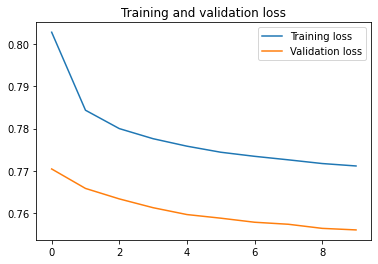

In [247]:
loss = history.history['loss'] 
val_loss = history.history['val_loss']
epochs = range(len(loss)) 

plt.plot(epochs, loss,  label='Training loss') 
plt.plot(epochs, val_loss,  label='Validation loss') 
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [254]:
history = model.fit(x_train, y_train, epochs=1, validation_data=(x_val, y_val), verbose = 1, batch_size=256, shuffle=False)

91/91 [==============================] - 19s 165ms/step - loss: 0.8259 - val_loss: 0.8060


## Model 10

In [255]:
model = Sequential()

model.add(layers.LSTM(64, recurrent_dropout=0.3, input_shape = (seq_len, num_feat), return_sequences = True))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(8, activation = 'relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1))

model.summary()

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_45 (LSTM)              (None, 30, 64)            17408     
                                                                 
 dense_83 (Dense)            (None, 30, 32)            2080      
                                                                 
 dropout_40 (Dropout)        (None, 30, 32)            0         
                                                                 
 dense_84 (Dense)            (None, 30, 16)            528       
                                                                 
 dropout_41 (Dropout)        (None, 30, 16)            0         
                                                                 
 dense_85 (Dense)            (None, 30, 8)             136       
                                                                 
 dropout_42 (Dropout)        (None, 30, 8)           

In [256]:
model.compile(loss = 'mae', optimizer='adam')

In [250]:
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), verbose = 1, batch_size=256, shuffle=False)

Epoch 1/10
91/91 [==============================] - 17s 146ms/step - loss: 0.8295 - val_loss: 0.8171
Epoch 2/10
91/91 [==============================] - 12s 137ms/step - loss: 0.8195 - val_loss: 0.8104
Epoch 3/10
91/91 [==============================] - 13s 141ms/step - loss: 0.8161 - val_loss: 0.8062
Epoch 4/10
91/91 [==============================] - 13s 140ms/step - loss: 0.8138 - val_loss: 0.8037
Epoch 5/10
91/91 [==============================] - 13s 143ms/step - loss: 0.8121 - val_loss: 0.8018
Epoch 6/10
91/91 [==============================] - 12s 137ms/step - loss: 0.8107 - val_loss: 0.8002
Epoch 7/10
91/91 [==============================] - 13s 141ms/step - loss: 0.8095 - val_loss: 0.7991
Epoch 8/10
91/91 [==============================] - 13s 139ms/step - loss: 0.8083 - val_loss: 0.7980
Epoch 9/10
91/91 [==============================] - 13s 139ms/step - loss: 0.8075 - val_loss: 0.7975
Epoch 10/10
91/91 [==============================] - 13s 139ms/step - loss: 0.8069 - val_lo

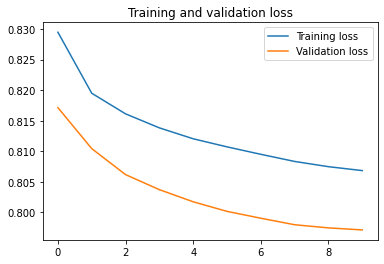

In [251]:
loss = history.history['loss'] 
val_loss = history.history['val_loss']
epochs = range(len(loss)) 

plt.plot(epochs, loss,  label='Training loss') 
plt.plot(epochs, val_loss,  label='Validation loss') 
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [257]:
history = model.fit(x_train, y_train, epochs=1, validation_data=(x_val, y_val), verbose = 1, batch_size=256, shuffle=False)

91/91 [==============================] - 18s 155ms/step - loss: 0.8362 - val_loss: 0.8153
